In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
RND_STATE = 51834
%matplotlib inline

## 1. Loading data

### 1.1 Data load from file

In [12]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

In [13]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 1.1 Data exploration

| Variable Name | Description | Type |
| :- | :- | :- |
| SeriousDlqin2yrs | Person experienced 90 days past due delinquency or worse | Y/N |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age | Age of borrower in years | integer |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| MonthlyIncome | Monthly income | real |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) | integer |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due. | integer |
| NumberRealEstateLoansOrLines | Number of mortgage and real estate loans including home equity lines of credit | integer |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer |
| NumberOfDependents | Number of dependents in family excluding themselves (spouse, children etc.) | integer |






### 1.2 Checking if classes are imbalanced

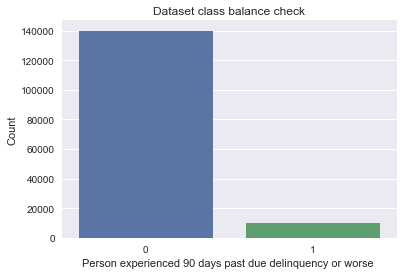

In [14]:
ax = sns.countplot(x = data.SeriousDlqin2yrs)
ax.set_title('Dataset class balance check')
ax.set_xlabel('Person experienced 90 days past due delinquency or worse ')
ax.set_ylabel('Count')
plt.show()

### 1.3 Checking for NAN values

In [15]:
def checkDataFrameNANs(df):
    print('Number of nans by property:')
    print(df.isnull().sum())

In [16]:
checkDataFrameNANs(data)

Number of nans by property:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## 2. Data preprocessing

### 2.1 Working with NANs

#### 2.1.1 Working with NumberOfDependents parameter 

Рассматриваемый датасет содержит пропуски в параметре NumberOfDependents. Пропусков достаточно немного, и, чтобы не удалять значения, заменим пропуски в данных медианными значениями.

In [17]:
data['NumberOfDependents'].fillna(data['NumberOfDependents'].median(), inplace = True)

#### 2.1.2 Working with MonthlyIncome parameter 

В используемом датасете очень много пустых значений параметра MonthlyIncome. 
Построим линейную регрессию для восстановления значений параметра.

In [18]:
non_null_data_monInc = data[data.MonthlyIncome.isnull() == False]
null_monInc = data[data.MonthlyIncome.isnull() == True]

monInc_y_train = non_null_data_monInc.MonthlyIncome
monInc_X_train = non_null_data_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis = 1)
null_monInc = null_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

monIncLR = LinearRegression(fit_intercept=True, normalize=True).fit(monInc_X_train, monInc_y_train)

С помощью полученной модели предскажем значения параметра для NAN значений 

In [19]:
monInc_y_pred = monIncLR.predict(null_monInc)
monInc_y_pred[monInc_y_pred < 0] = 0
null_monInc['MonthlyIncome'] = monInc_y_pred

In [20]:
monNew = []
for index in data.index:
    if data.MonthlyIncome[index].is_integer() == True:
        monNew.append(data.MonthlyIncome[index])
    else:
        monNew.append(null_monInc.MonthlyIncome[index])
data.MonthlyIncome = monNew

#### 2.1.3 Cheking for NANs again

In [23]:
print('Number of nans by property:')
checkDataFrameNANs(data)

Number of nans by property:
Number of nans by property:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 2.2 Oversampling minor class

In [24]:
X = data.drop('SeriousDlqin2yrs', axis = 1)
y = data.SeriousDlqin2yrs

In [25]:
sm = SMOTE(random_state = RND_STATE)
X_res, y_res = sm.fit_sample(X, y)

## 3. Data prediction

### 3.1 Train test split

In [ ]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RND_STATE)